# MNIST task with MLP bias neuron

Firstly, we train a binarized MNIST network.

In [60]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.autograd import Variable
from binarized_modules import  BinarizeLinear
from binarized_modules import  Binarize
import numpy as np
import math
from scipy.stats import binom
from utils import *

import matplotlib.pyplot as plt

In [61]:
#Loading the dataset
train_loader, test_loader = dataset_loader('./data/')

#Setting up the GPU
gpu = 1 #GPU position
device = get_default_device(gpu) #set the device (returns cpu if no gpu is available)

NVIDIA TITAN RTX


# Training the baseline network without errors

For the fully connected network simulations we first train our model on the MNIST dataset here. After this, we define the same model, but with the circuit-based implementations, and run our trained model with it.

In [62]:
#Defining the NN architecture
n_hidd = 3 #Number of hidden layers
n_hidd_neur = 1025 #Number of neurons in the hidden layers

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = BinarizeLinear(784, n_hidd_neur)
        self.bn1 = nn.BatchNorm1d(n_hidd_neur, affine=False)
                
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(n_hidd-1):
            self.linears.append(BinarizeLinear(n_hidd_neur, n_hidd_neur))
            self.bns.append(nn.BatchNorm1d(n_hidd_neur, affine=False))
        
        self.fc_last = BinarizeLinear(n_hidd_neur, 10)
        self.bn_last = nn.BatchNorm1d(10, affine=False)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.bn1(x)
        x = SignActivation.apply(x)
        
        for i in range(n_hidd-1):
            x = self.linears[i](x)
            x = self.bns[i](x)
            x = SignActivation.apply(x)
        
        x = self.fc_last(x)
        x = self.bn_last(x)
        
        return x

model = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [63]:
#Training the neural network
test_accuracy = []
n_epochs = 150

for epoch in range(1, n_epochs + 1):
    print("Epoch", epoch)
    train(epoch, model, device, train_loader, optimizer, criterion)
    test_acc = test(model, device, test_loader, criterion)
    test_accuracy.append(test_acc) 
    print(test_accuracy[-1])
    torch.save(model.state_dict(), '../MNIST_2_layer_params')
    if test_accuracy[-1] >=98.3:
        break
    scheduler.step()
        
    torch.save(model.state_dict(), '../MNIST_2_layer_params')
    

torch.save(model.state_dict(), '../MNIST_2_layer_params')

Epoch 1
96.26
Epoch 2
96.81
Epoch 3
97.27
Epoch 4
97.21
Epoch 5
97.4
Epoch 6
97.77
Epoch 7
97.71
Epoch 8
97.83
Epoch 9
97.63
Epoch 10
97.74
Epoch 11
97.83
Epoch 12
97.93
Epoch 13
97.98
Epoch 14
97.88
Epoch 15
97.93
Epoch 16
98.03
Epoch 17
98.08
Epoch 18
98.01
Epoch 19
98.04
Epoch 20
98.04
Epoch 21
97.98
Epoch 22
98.05
Epoch 23
98.17
Epoch 24
97.85
Epoch 25
98.02
Epoch 26
97.95
Epoch 27
98.03
Epoch 28
98.19
Epoch 29
97.94
Epoch 30
97.99
Epoch 31
98.07
Epoch 32
98.21
Epoch 33
98.39


# Testing the network with the circuit-based values

In [64]:
#Defining the neural network architecture with the circuit-based considerations

class Net_with_bias_neurons(nn.Module):
    def __init__(self):
        super(Net_with_bias_neurons, self).__init__()
        self.fc1 = BinarizeLinear(784, n_hidd_neur)
        self.bn1 = nn.BatchNorm1d(n_hidd_neur, affine=False)
                
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(n_hidd-1):
            self.linears.append(BinarizeLinear(n_hidd_neur, n_hidd_neur))
            self.bns.append(nn.BatchNorm1d(n_hidd_neur, affine=False))
        
        self.fc_last = BinarizeLinear(n_hidd_neur, 10)
        self.bn_last = nn.BatchNorm1d(10, affine=False)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.bn1(x)
        x = SignActivation.apply(x)
        
        for i in range(n_hidd-1):
            x = self.linears[i](x)
            x = BiasNeuron(device=device, inpt=x, N=1025, err=err_1025, th=model.bns[i].running_mean)
            x = SignActivation.apply(x)
        
        x = self.fc_last(x)
        
        return x

In [65]:
p_list = [0, 0.0001, 0.001, 0.002, 0.003, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]

n_samples = 30 #number of inference samples 
clk = 6 #clock speed (in ns)

results_array = np.zeros([n_samples, len(p_list)])

for p_idx, p in enumerate(p_list):
    print(p_idx, p)
    #Loading the error probabilities for the hidden layer
    err_1025 = np.loadtxt(f"./error_all/{clk}_ns/Full_error_prob_with_SA_clk_{clk}_ns_neurons_1025.txt")[:, p_idx]
    
    
    for i in range(n_samples):
        model = Net_with_bias_neurons().to(device)
        model.load_state_dict(torch.load(f="../MNIST_2_layer_params", map_location=torch.device('cpu')))
        acc_test = test(model, device, test_loader, criterion)

        results_array[i, p_idx] = acc_test
        #print(results_array)

0 0
1 0.0001
2 0.001
3 0.002
4 0.003
5 0.01
6 0.02
7 0.03
8 0.04
9 0.05
10 0.06
11 0.07
12 0.08
13 0.09
14 0.1
15 0.2
16 0.3
17 0.4
18 0.5


In [1]:
#Taking the average and mean over the inference samples

acc_mean_all_6_ns = results_array.mean(axis=0)
acc_std_all_6_ns = results_array.std(axis=0) 

#print(list(np.around(acc_mean_all_6_ns, 3)))
#print(list(np.around(acc_std_all_6_ns, 3)))

NameError: name 'results_array' is not defined

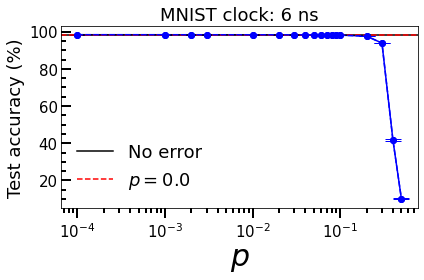

In [72]:
#Plotting the result
plot_params()

plt.plot(p_list[1:], acc_mean_all_6_ns[1:], 'bo-')
plt.errorbar(p_list[1:], acc_mean_all_6_ns[1:], yerr=acc_std_all_6_ns[1:], fmt='--bo',capsize=8, elinewidth=1.1, markeredgewidth=1);
plt.xscale('log');
plt.ylabel("Test accuracy (%)", size=18);
plt.xlabel("$p$", size=30);
plt.axhline(y=test_accuracy[-1], color='black', linestyle='-', label='No error');
plt.axhline(y=acc_mean_all_6_ns[0], color='red', linestyle='--', label='$p=0.0$');
plt.title("Clock speed: 6 ns", size=18);
plt.legend(loc='lower left', frameon=False, prop={'size':18});
plt.tight_layout()